In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle

%matplotlib inline

In [4]:
comments = open('dataset18000.txt', encoding='utf-8').readlines()
label = open('dataResult.txt').readlines()

data = pd.DataFrame({'comment': comments, 'label': label})
data.comment = data.comment.apply(lambda x: x.strip())
data.label = data.label.apply(lambda x: int(x.strip()))
data.label = data.label.astype('int32')

n_data = pd.read_csv('new_data.csv')
data = data.append(n_data, ignore_index=True)

data.tail()

,comment,label
20209,লসের সম্ভাবনা নাই,0
20210,হিন্দুদের কাছে শয়তানও হার মানে তারা হলো শয়তানে...,3
20211,আমার তো তোমারেই মনে পড়ে,0
20212,কোপালে জেয় কোন টিপ দেওয়া হারাম।,2
20213,অনেক সুনদর,0


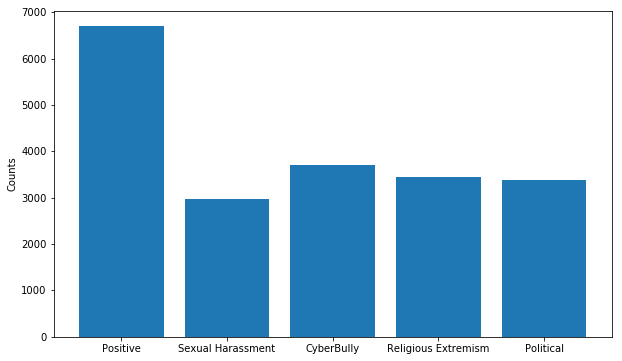

In [41]:
freq = data.label.value_counts()
freqs = [freq[x] for x in range(5)]

plt.figure(figsize=(10,6))
plt.bar([1, 2, 3, 4, 5], freqs, tick_label=['Positive', 'Sexual Harassment', 'CyberBully', 'Religious Extremism', 'Political'])
plt.ylabel('Counts')
plt.show()

In [7]:
vec = CountVectorizer(ngram_range=(1, 3))
vec.fit(data.comment.values)

X = vec.transform(data.comment.values)
Y = data.label.values

X_train = X[:15000]
Y_train = Y[:15000]

X_test = X[15000:18000]
Y_test = Y[15000:18000]

X_valid = X[18000:]
Y_valid = Y[18000:]

print(X.shape, Y.shape)

(20214, 72716) (20214,)


In [8]:
accs = []
#Naive Bayes
clf = MultinomialNB()
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
pred1 = clf.predict(X_valid)

acc = accuracy_score(Y_test, pred)
cnf = confusion_matrix(Y_valid, pred1)
print('Naive Bayes')
print('Accuracy:', acc)
print('Confusion Matrix:')
print(cnf)

accs.append(acc)

Naive Bayes
Accuracy: 0.754
Confusion Matrix:
[[684   1   9   8   8]
 [129 196  14   8   5]
 [124  10 246  16   8]
 [ 29   2   3 327   6]
 [  3   0   2   3 373]]


In [9]:
#Logistic Regression
clf = LogisticRegression()
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
pred1 = clf.predict(X_valid)

acc = accuracy_score(Y_test, pred)
cnf = confusion_matrix(Y_valid, pred1)
print('Logistic Regression')
print('Accuracy:', acc)
print('Confusion Matrix:')
print(cnf)

accs.append(acc)

Logistic Regression
Accuracy: 0.7946666666666666
Confusion Matrix:
[[685   9  13   3   0]
 [ 99 237  15   0   1]
 [ 94  10 297   0   3]
 [ 26   1   5 333   2]
 [  6   1   3   1 370]]


In [12]:
#SVM
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
pred1 = clf.predict(X_valid)

acc = accuracy_score(Y_test, pred)
cnf = confusion_matrix(Y_valid, pred1)
print('SVM')
print('Accuracy:', acc)
print('Confusion Matrix:')
print(cnf)

accs.append(acc)

SVM
Accuracy: 0.804
Confusion Matrix:
[[689   5  13   3   0]
 [ 96 244  11   0   1]
 [ 93   6 301   0   4]
 [ 25   1   4 337   0]
 [  5   1   2   0 373]]


In [14]:
#MLP
clf = MLPClassifier(hidden_layer_sizes=(10, ))
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
pred1 = clf.predict(X_valid)

acc = accuracy_score(Y_test, pred)
cnf = confusion_matrix(Y_valid, pred1)
print('MLP')
print('Accuracy:', acc)
print('Confusion Matrix:')
print(cnf)

accs.append(acc)

MLP
Accuracy: 0.798
Confusion Matrix:
[[670  10  26   4   0]
 [ 79 264   7   1   1]
 [ 66  11 326   0   1]
 [ 18   1   5 343   0]
 [  4   1   4   2 370]]


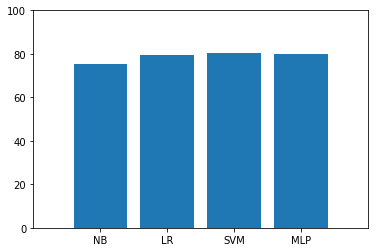

In [29]:
plt.bar([1, 2, 3, 4], [x*100 for x in accs], 0.8, tick_label=['NB', 'LR', 'SVM', 'MLP'])
plt.xlim(0, 5)
plt.ylim(0, 100)
plt.show()

In [30]:
f_vec = 'vectorizer.pkl'
f_lr = 'svm.pkl'

pickle.dump(vec, open(f_vec, 'wb'))

svm = SVC(kernel='linear')
svm.fit(X, Y)

pickle.dump(svm, open(f_lr, 'wb'))

print('Done...')

Done...
